# Importation des packages

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#@title Titre par défaut
from time import time
import numpy as np
import pandas as pd
import tensorflow as tf

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3


# TF IDF Imports


from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split  
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

from tensorflow.keras.callbacks import ModelCheckpoint

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [235]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [236]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()
save_data=data

In [237]:
from drive.MyDrive.RNN_sentiment_dataset.random_tweets import *

# Etude du jeu de données

Sur 100 données 

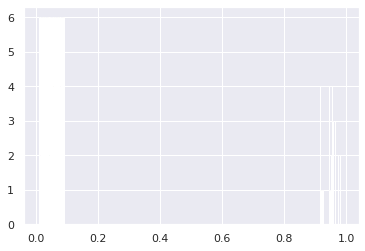

In [238]:
# observer tous la distribution des donnée de facons graphiques
# on remaque que la majoritée des données sont à 0 
y=data.iloc[0:100]
x=y[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]
plt.hist(x)
plt.show()

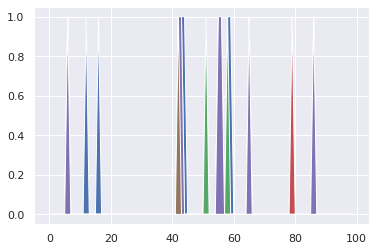

In [239]:
# observer la concentation des tweets négative dans la dataset
plt.fill(x)
plt.show()

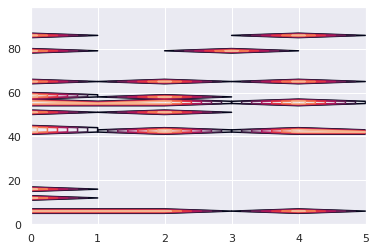

In [240]:
plt.contour(x)
plt.show()

In [241]:
#if (data.loc[i,["toxic"]]==1).values 

In [242]:
train_df = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/test.csv')
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [243]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
61381,a44e615a1297c9a2,aaa \n\nim undead dont plaey with me and and a...,0,0,0,0,0,0
130909,bc788ccb17c7f176,That is why I inserted a caveat that the artic...,0,0,0,0,0,0
96218,02a884f2cc4c6df2,16. Sources 14 and 17 are exactly the same. I...,0,0,0,0,0,0
105139,327b2f58e64212c6,COPYRIGHT INFRINGEMENT \n\nDanielle Blakey is ...,0,0,0,0,0,0
132432,c4a298f3c96ecbbc,I find it very hard to come to any firm conclu...,0,0,0,0,0,0


In [244]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [245]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [246]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


In [247]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [248]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [249]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


In [250]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [251]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

In [252]:

%matplotlib inline
import seaborn as sns
import re

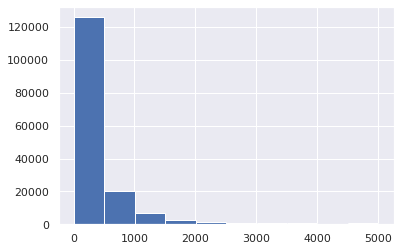

In [253]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

In [254]:
data = train_df[cols_target]

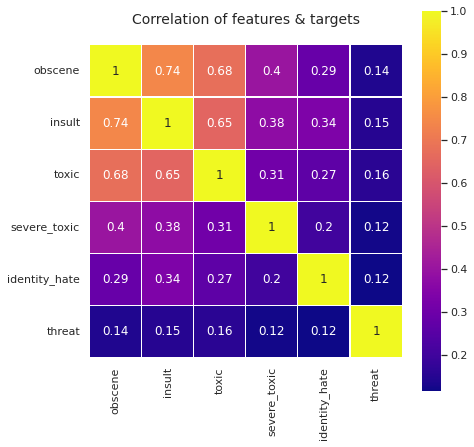

In [255]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [256]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

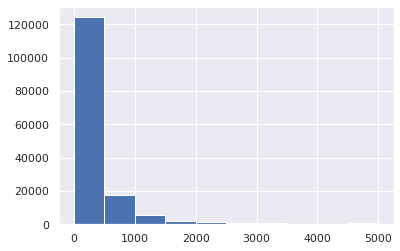

In [257]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

# Préparation des données

In [258]:
#@title Titre par défaut
tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [259]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet

In [260]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [261]:
def prepare_string(tweet):
  tweet = clean(tweet)
  tweet = convert_abbrev_in_text(tweet)
  return tweet

In [262]:
EX=save_data.iloc[0:10000] # entrenement avec les 10000 premier donnée

In [263]:
    # Apply prepare_string to all rows in 'tweets' column
EX['comment_text'] = EX['comment_text'].apply(lambda s : prepare_string(s))
    # Drop empty values from dataframe
EX['comment_text'].replace('', np.nan, inplace=True)
EX.dropna(subset=['comment_text'], inplace=True)

head_10=EX.loc[:,'comment_text'].head(10)
      # Using all the data exceeds the RAM capacity of the Notebook 
corpus_size = int(10000)

   
tweets = [*EX['comment_text'].values[:int(corpus_size/2)], *EX['comment_text'].values[-int(corpus_size/2):]]
    
y = [*EX[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values[:int(corpus_size/2)], *EX[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values[-int(corpus_size/2):]]
    # utilisation de TF-id
tfIdfVectorizer = TfidfVectorizer()
X = tfIdfVectorizer.fit_transform(tweets).toarray()
    #
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

    # Entraînement du modèle baseline

    # Use only 15 estimator to save your ram
text_classifier = RandomForestClassifier(n_estimators=15, random_state=0)  
text_classifier.fit(X_train, y_train )
predictions = text_classifier.predict_proba(X_test)


<ipython-input-263-4995cc6ec685>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EX['comment_text'] = EX['comment_text'].apply(lambda s : prepare_string(s))
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [264]:
prediction= text_classifier.predict(X_test)

In [265]:
print(classification_report(y_test,prediction))  
print(accuracy_score(y_test, prediction))


              precision    recall  f1-score   support

           0       0.96      0.48      0.64       228
           1       1.00      0.04      0.08        25
           2       0.96      0.44      0.60       121
           3       0.00      0.00      0.00        10
           4       0.77      0.35      0.48       114
           5       0.00      0.00      0.00        15

   micro avg       0.91      0.40      0.55       513
   macro avg       0.61      0.22      0.30       513
weighted avg       0.87      0.40      0.54       513
 samples avg       0.04      0.03      0.03       513

0.9168


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [273]:
print(predictions)  # afficher la sortie sous forme de probabiliter

[array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.86666667, 0.13333333],
       [1.        , 0.        ],
       [1.        , 0.        ]]), array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]]), array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.93333333, 0.06666667],
       [0.93333333, 0.06666667],
       [1.        , 0.        ]]), array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]]), array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.86666667, 0.13333333],
       [0.93333333, 0.06666667],
       [1.        , 0.        ]]), array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])]


# Entraînement du modèle baseline

# RNN & LSTM with GloVe

In [274]:
save_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more cannot make real suggestions improvement ...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir hero any chance remember page,0,0,0,0,0,0


In [275]:
data2=save_data

In [276]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 20        # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(corpus)
test_portion=.025

In [277]:
corpus = list(zip(data2[['comment_text']].values, data2[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values))
phrase=data2["comment_text"].values
labels=data2.loc[:, ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]

In [278]:
print(phrase)

['explanation why edits made username hardcore metallica fan reverted they vandalisms closure gas voted new york dolls fac and please remove template talk page since retired'
 'daww matches background colour seemingly stuck thanks talk january coordinated universal time'
 'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info'
 ...
 'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.'
 '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them.   "']


In [281]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(phrase)
word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(phrase)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



AttributeError: ignored

In [ ]:
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)


model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
        LSTM(units=128),
        tf.keras.layers.Dense(6, activation='softmax')
        
])
# enregistre le meilleur model dans /content/drive/MyDrive/data_classification sous le mon de save_model
Bmodel=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/data_classification/save_model.h5',
        save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)
      



    # sotmax en sortie parce qu'on a plusieurs valeur et 6 sortie une pour chaque type de donnée

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(training_padded, 
                            training_labels, 
                            epochs=10,
                            validation_data=(testing_padded, testing_labels),
                            batch_size = 256,
                            verbose=1,
                    callbacks=Bmodel)
                            
        
print("Training Complete")
  


In [ ]:
prediction=model.predict(training_padded)

In [ ]:
print(prediction)

### Entraînement d'un modèle en utilisant embedding

In [ ]:
#@title Graphe
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()




  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [ ]:
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]
num_epochs = 64

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

embeddings_index = {};
# preparation des données entrainement des données
with open('/content/drive/MyDrive/RNN_sentiment_dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
      embeddings_matrix[i] = embedding_vector; 
model = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
LSTM(units=64),
tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 10

# sauvegarde le meilleur model dans /content/drive/MyDrive/data_classification sous le nom de save_model1
Bmodel=tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/data_classification/save_model1.h5',
        save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)
      
training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels),
                    batch_size = 256,
                    verbose=1,
                    callbacks=Bmodel)
print("Training Complete")
 

In [ ]:
#@title Graphe
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()




  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [ ]:
# cette fonction permet de predire la négativité d'un tweets
def tweet_traiteur(tweets):

  #traitement des tweets
  tokenizer = TweetTokenizer(strip_handles=True)
  nltk.download('stopwords')
  stop_words = nltk.corpus.stopwords.words('english')
  for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
  tweet = tweet.replace('...', ' ... ')
  if '...' not in tweet:
      tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
  tweet_words = tokenizer.tokenize(tweet)
    

  tweets= prepare_string(tweets)
  # faire appel au model reçu par le RNN
  model=tf.keras.models.load_model('/content/drive/MyDrive/data_classification/save_model.h5')
  predicteur=model.predict(tweets)
  

  return predicteur
